<a href="https://colab.research.google.com/github/maximsachs/phishing_classification_recurrent_nn/blob/master/colab_Phishing_domain_name_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Getting the data from: https://github.com/maximsachs/phishing_classification_recurrent_nn
!wget https://raw.githubusercontent.com/maximsachs/phishing_classification_recurrent_nn/master/combined_online_valid.csv
!wget https://raw.githubusercontent.com/maximsachs/phishing_classification_recurrent_nn/master/top-1m_umbrella.csv

--2020-10-30 17:53:03--  https://raw.githubusercontent.com/maximsachs/phishing_classification_recurrent_nn/master/combined_online_valid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5010469 (4.8M) [text/plain]
Saving to: ‘combined_online_valid.csv.1’

combined_online_val 100%[===================>]   4.78M  24.0MB/s    in 0.2s    

2020-10-30 17:53:03 (24.0 MB/s) - ‘combined_online_valid.csv.1’ saved [5010469/5010469]

--2020-10-30 17:53:03--  https://raw.githubusercontent.com/maximsachs/phishing_classification_recurrent_nn/master/top-1m_umbrella.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... co

In [32]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from prettytable import PrettyTable
import tensorflow as tf

In [33]:
# Some high level parameters:
show_top_n = 20
random_seed = 16

# Setting the random seed so that the code is repeatable.
np.random.seed(random_seed)

In [34]:
# Loading the current combined online-valid dataset.
# Use the dataset_downloader.py to download the current Phishtank online-valid.csv and update the combined dataset.
print("Phishtank Online Valid Dataset")
online_valid_df = pd.read_csv("combined_online_valid.csv")
online_valid_df

Phishtank Online Valid Dataset


,Unnamed: 0,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,0,https://newproductsstore.com/oauth.paypal/myac...,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T18:19:40+00:00,yes,2020-10-24T19:54:47+00:00,yes,PayPal
1,1,http://dhj.wsaufan.cn/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:22:20+00:00,yes,2020-10-24T19:44:13+00:00,yes,Other
2,2,http://olivaspa.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:08:49+00:00,yes,2020-10-24T15:10:42+00:00,yes,Virustotal
3,3,https://olivaspa.com/index.php,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:05:11+00:00,yes,2020-10-24T15:06:54+00:00,yes,Virustotal
4,4,https://olivaspa.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:02:41+00:00,yes,2020-10-24T15:04:34+00:00,yes,Virustotal
...,...,...,...,...,...,...,...,...
23731,23731,http://www.gtodontotecnica.it/smbs/nedbank/mfs...,http://www.phishtank.com/phish_detail.php?phis...,2020-10-23T08:57:54+00:00,yes,2020-10-23T09:00:20+00:00,yes,Other
23732,23732,http://abelsonscopeworks.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-26T16:05:56+00:00,yes,2020-10-26T16:58:15+00:00,yes,Other
23733,23733,https://0992334.weebly.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-26T14:06:31+00:00,yes,2020-10-26T14:12:02+00:00,yes,Other
23734,23734,https://gruppwaa139.my03.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-26T14:05:00+00:00,yes,2020-10-26T14:10:34+00:00,yes,Other


In [35]:
# Extracting tld and domain name.
tld_count = defaultdict(lambda: 0)
domain_names = []
for index, row in online_valid_df.iterrows():
    # Extracting the tld from the url
    domain_name = row["url"].replace("https://","").replace("http://","").split("/")[0]
    domain_names.append(domain_name)
    tld = domain_name.split(".")[-1]
    tld_count[tld] += 1

tld_df = pd.Series(dict(tld_count))
tld_df.sort_values(ascending=False, inplace=True)
tld_print = tld_df.iloc[:show_top_n]
tld_print["OTHERS"] = tld_df.iloc[show_top_n:].sum()

In [36]:
# Adding the domain names extracted from the phishing urls as a new column.
online_valid_df["domain_names"] = domain_names

In [37]:
# Loading the whitelist from the 1 million most frequently visited domains.
whitelist_file_umbrella = "top-1m_umbrella.csv"
whitelist_df = pd.read_csv(whitelist_file_umbrella, header=None, names=["rank", "domain_names"])

In [38]:
# Finding if there are any domains that are also in the whitelist.
domains_in_whitelist = np.intersect1d(online_valid_df["domain_names"], whitelist_df["domain_names"])
# Tagging the whitelisted domains as such.
online_valid_df["in_whitelist"] = np.in1d(online_valid_df["domain_names"], domains_in_whitelist)

In [39]:
# Printing some data examples for reference.
print(online_valid_df.shape[0], "rows")
print(tld_print.to_frame(name="TLD Count").transpose().to_string())
print(f"Percentage of top {show_top_n} tlds: {np.round(100*tld_df.iloc[:show_top_n].sum()/tld_df.sum(), decimals=2)} %")
online_valid_df.head(20)

23736 rows
             com   ru  net  org   br  xyz   uk  top  info   ph   in  link   id   cc   cn   ly   fr   io   de   it  OTHERS
TLD Count  13905  945  776  477  373  360  354  339   243  235  221   211  205  174  164  146  144  144  139  135    4046
Percentage of top 20 tlds: 82.95 %


,Unnamed: 0,url,phish_detail_url,submission_time,verified,verification_time,online,target,domain_names,in_whitelist
0,0,https://newproductsstore.com/oauth.paypal/myac...,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T18:19:40+00:00,yes,2020-10-24T19:54:47+00:00,yes,PayPal,newproductsstore.com,False
1,1,http://dhj.wsaufan.cn/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:22:20+00:00,yes,2020-10-24T19:44:13+00:00,yes,Other,dhj.wsaufan.cn,False
2,2,http://olivaspa.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:08:49+00:00,yes,2020-10-24T15:10:42+00:00,yes,Virustotal,olivaspa.com,False
3,3,https://olivaspa.com/index.php,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:05:11+00:00,yes,2020-10-24T15:06:54+00:00,yes,Virustotal,olivaspa.com,False
4,4,https://olivaspa.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T15:02:41+00:00,yes,2020-10-24T15:04:34+00:00,yes,Virustotal,olivaspa.com,False
5,5,http://izacourier.com/index.php,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T14:17:39+00:00,yes,2020-10-24T14:18:44+00:00,yes,Virustotal,izacourier.com,False
6,6,https://izacourier.com/index.php,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T14:10:49+00:00,yes,2020-10-24T14:12:41+00:00,yes,Virustotal,izacourier.com,False
7,7,https://izacourier.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T14:07:12+00:00,yes,2020-10-24T14:09:38+00:00,yes,Virustotal,izacourier.com,False
8,8,https://www.msn.autheticathor.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T14:06:07+00:00,yes,2020-10-24T21:11:58+00:00,yes,Other,www.msn.autheticathor.com,False
9,9,http://ftaqdxdsljuxbemvdgpkeoqhmmglnrscfsgz-do...,http://www.phishtank.com/phish_detail.php?phis...,2020-10-24T14:06:03+00:00,yes,2020-10-24T21:11:58+00:00,yes,Other,ftaqdxdsljuxbemvdgpkeoqhmmglnrscfsgz-dot-cedar...,False


In [40]:
# Printing the top of the whitelist.
print("Whitelist file:", whitelist_file_umbrella)
print(whitelist_df.shape[0], "rows")
print(whitelist_df.head(20))

Whitelist file: top-1m_umbrella.csv
1000000 rows
    rank                     domain_names
0      1                       google.com
1      2                   www.google.com
2      3                    microsoft.com
3      4                     facebook.com
4      5                      netflix.com
5      6                windowsupdate.com
6      7                  ftl.netflix.com
7      8             prod.ftl.netflix.com
8      9               data.microsoft.com
9     10           api-global.netflix.com
10    11          ctldl.windowsupdate.com
11    12        nrdp.prod.ftl.netflix.com
12    13                  doubleclick.net
13    14                g.doubleclick.net
14    15      safebrowsing.googleapis.com
15    16  settings-win.data.microsoft.com
16    17                      youtube.com
17    18      googleads.g.doubleclick.net
18    19        events.data.microsoft.com
19    20                         live.com


In [41]:
# How many domains are in both the whitelist and in the phishing urls?
print()
print("Number of urls that have domains which are in the whilelist:", online_valid_df["in_whitelist"].sum())


Number of urls that have domains which are in the whilelist: 1442


In [42]:
# For the dataset, excluding all where the domain name is in the whitelist.
# Since if the domain is in both lists we cannot tell if its safe or phishing? --> This helps with labeleling the data.
online_valid_df_without_intersection = online_valid_df.loc[online_valid_df['in_whitelist'] == False]
whitelist_df_without_intersection = whitelist_df.loc[np.invert(whitelist_df['domain_names'].isin(domains_in_whitelist))]

In [43]:
# Set oversampling_rate to 1 to have the positive samples match the phishing samples. Set to greater than 1 to use more negative samples.
oversampling_rate = 1.5

# Getting the array of all phishing domain names.
phishing_domains = online_valid_df_without_intersection["domain_names"].values
# Randomly sample a number of safe urls, sice the ratio of classes in the training data should not be too much out of balance.
whitelist_domains = np.random.choice(whitelist_df_without_intersection["domain_names"].values, size=int(oversampling_rate*len(phishing_domains)), replace=False)

In [44]:
print("Selected Data Examples:")
print("Phishing domains:", phishing_domains, len(phishing_domains))
print("Benign domains:", whitelist_domains, len(whitelist_domains))

Selected Data Examples:
Phishing domains: ['newproductsstore.com' 'dhj.wsaufan.cn' 'olivaspa.com' ...
 '0992334.weebly.com' 'gruppwaa139.my03.com' 'bungaabeauty.com'] 22294
Benign domains: ['co.th.lan' 'ext.selected-search.com' 'visio.officeapps.live.com' ...
 'inkelme.cf' 'c.adskeeper.co.uk' 'blog.panggin.org'] 33441


In [45]:
# Calling a phishing url 1 and a not-phishing url 0.
# Using character encoding as the vocabulary.
# Feeding the url as the sequence.
# Creating the samples array and the label array
print()
X = list(phishing_domains) + list(whitelist_domains)
y = [1]*len(phishing_domains) + [0]*len(whitelist_domains)
sample_weights = [1]*len(phishing_domains) + [1/oversampling_rate]*len(whitelist_domains)

In [46]:
# Encoding code/idea from TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial freeCodeCamp.org
# https://colab.research.google.com/drive/1ysEKrw_LE2jMndo1snrZUh5w87LQsCxk#forceEdit=true&sandboxMode=true
vocab = sorted(set("".join(X)), reverse=True)
# Inserting a space at index 0, since it is not used in url and will be used for padding the examples.
vocab.insert(0, " ")
vocab_size = len(vocab)

print()
print(f"Encoding Vocabulary ({vocab_size}) used:")
print(vocab)
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

print("Encoding example:")
print(text_to_int(phishing_domains[0]))

def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_to_int(phishing_domains[0])))


Encoding Vocabulary (73) used:
[' ', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '_', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '@', '?', '=', ';', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '.', '-', '&', '#']
Encoding example:
[13 22  4 11  9 12 23  6 24  7  8  8  7 12  9 22 69 24 12 14]
newproductsstore.com


In [47]:
# Investigating the domain name length for the combined domain names:
X_elem_len = [len(domain_name) for domain_name in X]
print(sorted(X_elem_len, reverse=True)[:show_top_n])

[926, 179, 178, 150, 150, 150, 122, 113, 113, 111, 105, 105, 104, 102, 102, 102, 100, 95, 95, 94]


In [48]:
# Setting some max length for our urls.
max_seq_len = 40
print((np.array(X_elem_len) > max_seq_len).sum(), "URLs longer than the cutoff length", max_seq_len)

4520 URLs longer than the cutoff length 40


In [49]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(np.array(X), 
                                                                                               np.array(y),
                                                                                               np.array(sample_weights),
                                                                                               test_size=0.15,
                                                                                               random_state=random_seed)

In [50]:
# Reducing how many samples to print so printouts dont get so big.
show_top_n = 5
print(f"Training and testing data: (showing first {show_top_n})")
print(f"Train data {len(X_train)} samples")
print(list(zip(X_train[:show_top_n], y_train[:show_top_n], sample_weights_train[:show_top_n])))
print(f"Test data {len(X_test)} samples")
print(list(zip(X_test[:show_top_n], y_test[:show_top_n], sample_weights_test[:show_top_n])))

Training and testing data: (showing first 5)
Train data 47374 samples
[('p.adnxs.com', 0, 0.6666666666666666), ('danar.net.pl', 0, 0.6666666666666666), ('tenzinngodup.com', 1, 1.0), ('metrolagu.ltd', 0, 0.6666666666666666), ('messages.monster-strike.com.tw', 0, 0.6666666666666666)]
Test data 8361 samples
[('tcprelay.ztehome.com.cn', 0, 0.6666666666666666), ('televoip.com.ve', 1, 1.0), ('ransecuritysoc.com', 0, 0.6666666666666666), ('my-site219.yolasite.com', 1, 1.0), ('mediaserver-cont-dc6-2-v4v6.pandora.com', 0, 0.6666666666666666)]


In [51]:
# Encoding the domain names using the vocabulary
X_train_encoded = [text_to_int(domain_name) for domain_name in X_train]
X_test_encoded = [text_to_int(domain_name) for domain_name in X_test]
print()
print(f"Encoded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded)} samples, encoded")
print(list(zip(X_train_encoded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded)} samples, encoded")
print(list(zip(X_test_encoded[:show_top_n], y_test[:show_top_n])))

# Padding to the right sequence length.
X_train_encoded_padded = sequence.pad_sequences(X_train_encoded, max_seq_len)
X_test_encoded_padded = sequence.pad_sequences(X_test_encoded, max_seq_len)
print()
print(f"Encoded and padded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded_padded)} samples, encoded")
print(list(zip(X_train_encoded_padded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded_padded)} samples, encoded")
print(list(zip(X_test_encoded_padded[:show_top_n], y_test[:show_top_n])))


Encoded data: (showing first 5)
Train data 47374 samples, encoded
[(array([11, 69, 26, 23, 13,  3,  8, 69, 24, 12, 14]), 0), (array([23, 26, 13, 26,  9, 69, 13, 22,  7, 69, 11, 15]), 0), (array([ 7, 22, 13,  1, 18, 13, 13, 20, 12, 23,  6, 11, 69, 24, 12, 14]), 1), (array([14, 22,  7,  9, 12, 15, 26, 20,  6, 69, 15,  7, 23]), 0), (array([14, 22,  8,  8, 26, 20, 22,  8, 69, 14, 12, 13,  8,  7, 22,  9, 70,
        8,  7,  9, 18, 16, 22, 69, 24, 12, 14, 69,  7,  4]), 0)]
Test data 8361 samples, encoded
[(array([ 7, 24, 11,  9, 22, 15, 26,  2, 69,  1,  7, 22, 19, 12, 14, 22, 69,
       24, 12, 14, 69, 24, 13]), 0), (array([ 7, 22, 15, 22,  5, 12, 18, 11, 69, 24, 12, 14, 69,  5, 22]), 1), (array([ 9, 26, 13,  8, 22, 24,  6,  9, 18,  7,  2,  8, 12, 24, 69, 24, 12,
       14]), 0), (array([14,  2, 70,  8, 18,  7, 22, 66, 67, 59, 69,  2, 12, 15, 26,  8, 18,
        7, 22, 69, 24, 12, 14]), 1), (array([14, 22, 23, 18, 26,  8, 22,  9,  5, 22,  9, 70, 24, 12, 13,  7, 70,
       23, 24, 62, 70, 66

In [52]:
def evaluate_nn_model(X, y, threshold=0.5, bins=5, graph_bins=15, examples_per_bin=15):
    """
    Custom nn evaluation to get the TP, TN, FP, FN rates.
    Anything below threshold is considered not phishing.
    Anything above threshold is considered phishing.
    """
    predictions = model.predict(X).flatten()
    mean_prediction = np.mean(predictions)
    print(f"Calculated {len(predictions)} predictions with a mean value of {mean_prediction}")
    print(f"Evaluating using threshold {threshold}")
    # Turning the predictions into 0 and 1 by checking the threshold. (0 safe, 1 phishing)
    predictions_boolean = predictions > threshold
    predictions_binary = predictions_boolean.astype(np.int)
    print(f"Cut-off threshold: {np.round(threshold, decimals=4)}")
    groundtruth_elements, groundtruth_counts = np.unique(y, return_counts=True)
    groundtruth_counts = dict(zip(groundtruth_elements, groundtruth_counts))
    evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
    statistics_table_printer(evaluation_ratios_counts)
    # showing some examples for each type of outcome: 0 TN, 1 FP, 2 FN, 3 TP
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    outcome_index = [0, 1, 2, 3]
    outcome_plot_positions = [0, 1, 2, 3]
    outcome_labels = ["TN", "FP", "FN", "TP"]
    y_axis_max = 0
    for outcome in outcome_index:
        outcome_indexes = np.where(np.array(sample_outcomes) == outcome)[0]
        # Instead of random samples, do a histogram with bins of the predictions for this outcome.
        # Then sample examples from each bin.
        outcome_predictions = predictions[outcome_indexes]
        outcome_binary = [ int(ind) for ind in list(str(bin(outcome_plot_positions[outcome])).replace("0b","").rjust(2, "0"))]
        outcome_hist, outcome_bins = np.histogram(outcome_predictions, bins=bins)
        plot_hist, plot_bins = np.histogram(outcome_predictions, bins=graph_bins)
        outcome_total_count = groundtruth_counts[outcome_binary[0]]
        plot_hist = (100*np.array(plot_hist))/outcome_total_count
        axs[outcome_binary[0], outcome_binary[1]].bar(plot_bins[:-1], plot_hist, width = plot_bins[1]-plot_bins[0], align="edge")
        y_axis_max = max( max(plot_hist), y_axis_max)
        axs[outcome_binary[0], outcome_binary[1]].set_title(outcome_labels[outcome])
        # Randomly sample some examples from each bin for this outcome:
        for bin_start, bin_end in zip(outcome_bins[:-1], outcome_bins[1:]):
            bin_outcome_indexes = np.where( np.logical_and( np.array(outcome_predictions) >= bin_start, np.array(outcome_predictions) < bin_end ))[0]
            bin_outcome_indexes = outcome_indexes[bin_outcome_indexes]
            if len(bin_outcome_indexes) > examples_per_bin:
                chosen_bin_outcome_examples = np.random.choice(bin_outcome_indexes, size=examples_per_bin, replace=False)
            else:
                chosen_bin_outcome_examples = bin_outcome_indexes
            example_truth = y[chosen_bin_outcome_examples]
            example_input_encoded = X[chosen_bin_outcome_examples]
            example_input_decoded = [ int_to_text(example).strip() for example in example_input_encoded]
            example_prediction = predictions[chosen_bin_outcome_examples]
            example_df = pd.DataFrame(data={"input": example_input_decoded, "ground truth": example_truth, "prediction": example_prediction})
            print("\nExamples for", outcome_labels[outcome], "Bin range:", bin_start, "-", bin_end, ", Num. Samples:", len(bin_outcome_indexes))
            print(example_df.to_string())
    for ax in axs.flat:
        ax.set(xlabel='Prediction', ylabel='Percentage of samples')
        ax.set_ylim(0, y_axis_max*1.02)
        ax.grid()
    plt.tight_layout()
    fig.savefig('outcome_distributions.pdf')
    return mean_prediction

def statistics_evaluator(predictions_binary, y_binary):
    # Concattenating the strings of the binary value of the prediction and the truth.
    # First value is the prediction, second the actual label
    # Hypothesis is: is phishing -> positive: yes phishing, negative: no phishing
    # Then 00 would be a TN, 01 is a FP, 10 is a FN, 11 is a TP. 
    # Converting the binary outcomes to integer: 0 TN, 1 FP, 2 FN, 3 TP
    hypothesis_tests = [int(str(label)+str(prediction), 2) for prediction, label in zip(predictions_binary, y_binary)]
    # Counting the number of times each unique value in the tests is returned.
    unique_elements, counts_elements = np.unique(hypothesis_tests, return_counts=True)
    counts_elements = dict(zip(unique_elements, counts_elements))
    outcome_labels = ["TN", "FP", "FN", "TP"]
    evaluation_ratios_counts = dict(zip(outcome_labels, [counts_elements.get(0, 0), counts_elements.get(1, 0), counts_elements.get(2, 0), counts_elements.get(3, 0)]))
    return evaluation_ratios_counts, hypothesis_tests

def statistics_table_printer(evaluation_ratios_counts, decimals=3):
    print("Evaluation counts:", evaluation_ratios_counts)
    try:
        positive_predictive_value = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        positive_predictive_value = 0
    try:
        true_positive_rate = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        true_positive_rate = 0
    try:
        false_discovery_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        false_discovery_rate = 0
    try:
        false_positive_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["FP"]+evaluation_ratios_counts["TN"])
    except:
        false_positive_rate = 0
    try:
        false_omission_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        false_omission_rate = 0
    try:
        false_negative_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        false_negative_rate = 0
    try:
        negative_predictive_value = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        negative_predictive_value = 0
    try:
        true_negative_rate = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FP"])
    except:
        true_negative_rate = 0
    try:
        accuracy = (evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0))/(evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0) + evaluation_ratios_counts.get("FP",0) + evaluation_ratios_counts.get("FN",0))
    except:
        accuracy = 0
    t = PrettyTable([f"Accuracy {np.round(accuracy*100, decimals=decimals)}%",
                     'Predicted safe',
                     'Predicted phishing'])
    t.add_row(["Not phishing",
               "TN: {TN}".format(**evaluation_ratios_counts),
               "FP: {FP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"NPV: {np.round(negative_predictive_value*100, decimals=decimals)}%",
                   f"FDR: {np.round(false_discovery_rate*100, decimals=decimals)}%"])
    t.add_row(['', f"TNR: {np.round(true_negative_rate*100, decimals=decimals)}%",
                   f"FPR: {np.round(false_positive_rate*100, decimals=decimals)}%"])
    t.add_row(["Is phishing",
               "FN: {FN}".format(**evaluation_ratios_counts), 
               "TP: {TP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"FOR: {np.round(false_omission_rate*100, decimals=decimals)}%",
                   f"PPV: {np.round(positive_predictive_value*100, decimals=decimals)}%"])
    t.add_row(['', f"FNR: {np.round(false_negative_rate*100, decimals=decimals)}%", 
                   f"TPR: {np.round(true_positive_rate*100, decimals=decimals)}%"])
    print(t)

def threshold_evaluation_plotter(X, y, min_threshold=0.05, max_threshold=0.95, steps=200, decimals=3):
    predictions = model.predict(X).flatten()
    stat_counts = []
    # Sweeping over the ranges.
    for threshold in np.linspace(min_threshold, max_threshold, steps):
        predictions_boolean = predictions > threshold
        predictions_binary = predictions_boolean.astype(np.int)
        evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
        stat_counts.append(evaluation_ratios_counts)
    counts_df = pd.DataFrame(data=stat_counts, index=np.linspace(min_threshold, max_threshold, steps))
    stat_df = pd.DataFrame(index=np.linspace(min_threshold, max_threshold, steps))
    # Calculating the stats:
    stat_df["accuracy"] = (counts_df["TP"]+counts_df["TN"])/(counts_df["TP"]+counts_df["TN"]+counts_df["FP"]+counts_df["FN"])
    stat_df["PPV"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["TPR"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["FDR"] = counts_df["FP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["FPR"] = counts_df["FP"]/(counts_df["FP"]+counts_df["TN"])
    stat_df["FOR"] = counts_df["FN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["FNR"] = counts_df["FN"]/(counts_df["TP"]+counts_df["FN"])
    stat_df["NPV"] = counts_df["TN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["TNR"] = counts_df["TN"]/(counts_df["FP"]+counts_df["TN"])
    fig = stat_df.plot(kind='line',  figsize=(20, 7), fontsize=16, lw=3).get_figure()
    plt.tight_layout()
    plt.grid()
    fig.savefig('threshold_statistics_sweep.pdf')
    print("Best performance at threshold:", stat_df['accuracy'].idxmax())
    return stat_df['accuracy'].idxmax()

def predict_url(url):
    encoded_text = sequence.pad_sequences([text_to_int(url)], max_seq_len)
    result = model.predict(encoded_text) 
    print("Prediction on url:", url, result[0][0])

In [53]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128,activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [54]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          4672      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 120,129
Trainable params: 120,129
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
class_weight={0: (1/(oversampling_rate+1)), 1: (oversampling_rate/(oversampling_rate+1))}
print("Using the class weighting:", class_weight)
# Training the model
# Setting up callback to monitor the selected loss, and stops training if it doesnt improve for patience-number of epochs.
# After stopping training will restore the weights from the best iteration on this value encountered so far.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Using the class weighting: {0: 0.4, 1: 0.6}


In [56]:
history = model.fit(X_train_encoded_padded, y_train,
                    epochs=100,
                    validation_data=(X_test_encoded_padded, y_test),
                    class_weight=class_weight,
                    sample_weight=sample_weights_train,
                    callbacks=[early_stopping_callback])

Epoch 1/100
1481/1481 [==============================] - 10s 6ms/step - loss: 0.1902 - acc: 0.7214 - val_loss: 0.4513 - val_acc: 0.7696
Epoch 2/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1645 - acc: 0.7670 - val_loss: 0.4382 - val_acc: 0.7738
Epoch 3/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1548 - acc: 0.7836 - val_loss: 0.4749 - val_acc: 0.7568
Epoch 4/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1471 - acc: 0.7966 - val_loss: 0.4007 - val_acc: 0.7970
Epoch 5/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1382 - acc: 0.8094 - val_loss: 0.4170 - val_acc: 0.7913
Epoch 6/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1313 - acc: 0.8221 - val_loss: 0.3792 - val_acc: 0.8226
Epoch 7/100
1481/1481 [==============================] - 9s 6ms/step - loss: 0.1235 - acc: 0.8356 - val_loss: 0.3822 - val_acc: 0.8157
Epoch 8/100
1481/1481 [==============================]

In [57]:
# Model built in evaluate
results = model.evaluate(X_test_encoded_padded, y_test)
print(results)

262/262 [==============================] - 1s 3ms/step - loss: 0.3294 - acc: 0.8565
[0.3293514847755432, 0.8564764857292175]


In [58]:
# Testing some handcrafted examples to see how it does.
print("\nPhishing ULR examples:")
predict_url("frgcxtmjawefgrthdcusge.dab")
predict_url("evilmadeupurl.phish")
predict_url("evil.madeupurl.phish")

print("\nSafe URL examples:")
predict_url("google.com")
predict_url("www.google.com")
predict_url("gmail.google.com")
predict_url("mail.google.com")
predict_url("tudelft.nl")
predict_url("brightspace.tudelft.nl")
predict_url("colab.research.google.com")
predict_url("00-gayrettepe-t3-8---00-gayrettepe-xrs-t2-1.statik.turktelekom.com.tr")


Phishing ULR examples:
Prediction on url: frgcxtmjawefgrthdcusge.dab 0.029374275
Prediction on url: evilmadeupurl.phish 0.6535125
Prediction on url: evil.madeupurl.phish 0.18197966

Safe URL examples:
Prediction on url: google.com 0.04181947
Prediction on url: www.google.com 0.09977573
Prediction on url: gmail.google.com 0.0022916235
Prediction on url: mail.google.com 0.0011315699
Prediction on url: tudelft.nl 0.07059877
Prediction on url: brightspace.tudelft.nl 0.9962966
Prediction on url: colab.research.google.com 0.0012517852
Prediction on url: 00-gayrettepe-t3-8---00-gayrettepe-xrs-t2-1.statik.turktelekom.com.tr 0.16847374


Best performance at threshold: 0.6967336683417086
Calculated 8361 predictions with a mean value of 0.4498916268348694
Evaluating using threshold 0.6967336683417086
Cut-off threshold: 0.6967
Evaluation counts: {'TN': 4517, 'FP': 525, 'FN': 544, 'TP': 2775}
+------------------+----------------+--------------------+
| Accuracy 87.214% | Predicted safe | Predicted phishing |
+------------------+----------------+--------------------+
|   Not phishing   |    TN: 4517    |      FP: 525       |
|                  |  NPV: 89.251%  |    FDR: 15.909%    |
|                  |  TNR: 89.587%  |    FPR: 10.413%    |
|   Is phishing    |    FN: 544     |      TP: 2775      |
|                  |  FOR: 10.749%  |    PPV: 84.091%    |
|                  |  FNR: 16.39%   |    TPR: 83.61%     |
+------------------+----------------+--------------------+

Examples for TN Bin range: 0.00064611493 - 0.13979572 , Num. Samples: 3428
                                       input  ground truth  prediction
0      

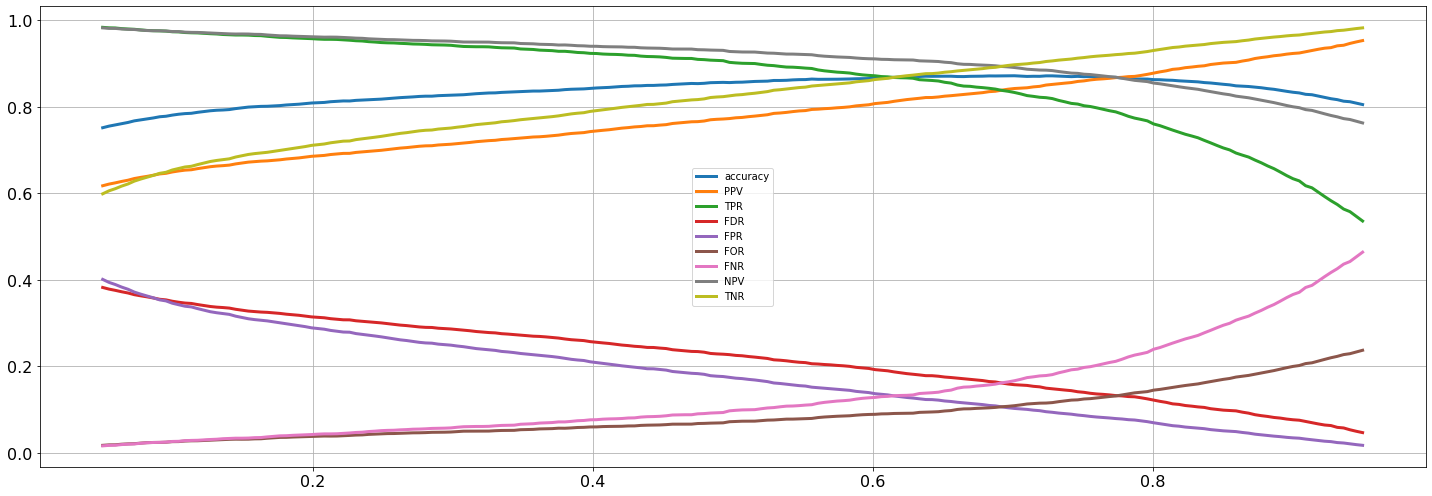

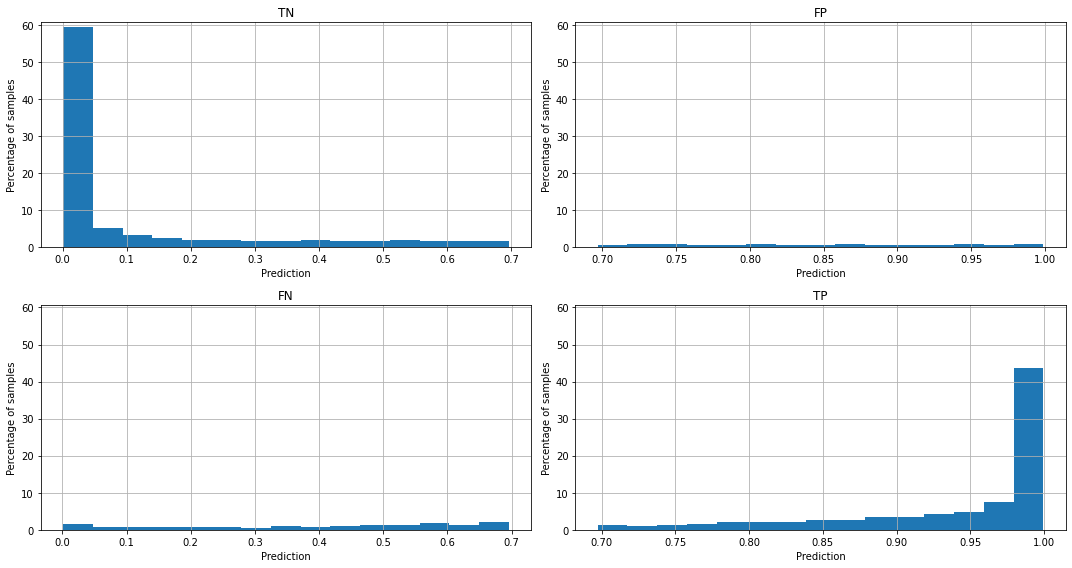

In [59]:
# Custom evaluate
best_threshold = threshold_evaluation_plotter(X_test_encoded_padded, y_test)
mean_prediction = evaluate_nn_model(X_test_encoded_padded, y_test, threshold=best_threshold)